<a href="https://colab.research.google.com/github/cbevis/SF_311/blob/master/311_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Analysis of San Francisco 311 Data 
Data: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6
<br><br>
San Francisco receives thousands of 311, or non-emergency service requests each year.  The requests are classified as different types.  Most of these requests also contain an image of the reported issue. I want to predict what kind of service request it is from the image.
<br><br>
Predicting the type of request from the image could save time in reporting issues since people would need to fill out fewer form attributes.  This could encourage more people to submit a request and help San Francisco to be better maintained.  It could also help the city confirm that requests are correctly submitted and for resource allocation. 
<br><br>
My data comes from San Francisco open data.  There are 3.48M available samples in the data set.  If an image was provided with the service request, a URL is included in the data set.  Requests was used to query these URLs and download images.  Due to RAM and time constraints, this analysis was limited to images taken in 2017 and 2018.   I used requests.get to download the images associated with the data points, and this resulted in about 160,000 classified images. 
<br><br>
Exploratory data analysis was used to look at the categorical variables associated with each of the downloaded samples.  Street, neighborhood, day of the week, and month were included.  A random forest classifier was used to determine a baseline for what kind of accuracy coud be expected from running a model on just the categorical data.
<br><br>
Next, neural networks were used to classify the samples by image.  The first attempt to model the data was with a convoluted neural network I created.  After tuning, this neural network achieved an accuracy of 48%.  I then used VGG16 to model the image data.  The accuracy of the model imporved to 50% with the use of the pretrained model.  Next, I modeled the categorical data using a multi-level perceptron model.  Once I achieved similar accuracy as the random forest model I had previously created for the data, I considered it tuned.  <br><br>
My next step was to see what would happen when I combined models.  Combining just the VGG16 model and the MLP model resulted in a lower accuracy in the 30s, even after trying many variations of including fully connected layers and dropout after the data in concatenated.  However, when all three models are combined (CNN, VGG16, MLP), my top accuracy improves from 50% to 52%.  
<br><br>




In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from numpy import random
from PIL import Image
from itertools import cycle, compress

# Import components for model building
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import concatenate, Input
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

# Import the keras backend
from keras import backend as K

# Import sklearn functions
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Used for interpolating roc curves
from scipy import interp


% matplotlib inline

Using TensorFlow backend.


In [2]:
# Check for GPU on Google Colabs
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Access the drive for the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Load in the Data
My data is in pickle files of 1,000 samples per file.  The pickle files are of pandas dataframes including features from the data set and grayscale flattedened 128x128 in an images column.  I read in the data into a pandas CSV and then drop columns that are not needed for modeling in order to save memory space.  Reading in these grayscale images takes about 3.8GB of RAM once they are read in and reshaped.  If this is done with RGB images at some point, the images will need to be read in during the generator files instead of all at once here since triplicating the number of channels exceeds the available RAM I have for free with Google co-labs.  This is why when I create pseudo RGB images (triplicating the grayscale channel) to use VGG16, I have to do it in a generator instead of here.

In [4]:
# Data path on Google Drive with my images
data_path = '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_[0-9]*.gzde'
# Generates a list of filenames to read in
files = glob.glob(data_path)
print('{} files uploaded.'.format(len(files)))
# Sort for repeatability - otherwise they load in different orders each time
files = sorted(files)

# Read in the pickle files, unpickle them, and concatenate into a single
# Dataframe.  If low on RAM, this could be done in the generators.
df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])

# Lowercase the column names and remove spaces
columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns

# Drop files without an image - usually files where the image was submitted
# via Twitter
df.dropna(subset=['image'], inplace=True)

# Update image types
df['opened'] = pd.to_datetime(df['opened'])
df['month'] = df['month'].astype('int16')
df['caseid'] = df['caseid'].astype('int')
df['neighborhood'] = df['neighborhood'].astype('category')
df['street'] = df['street'].astype('category')
df['category'] = df['category'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('str')
df['street'] = df['street'].astype('str')  

# Also add day of week to the dataframe
df['day'] = df['opened'].dt.dayofweek

166 files uploaded.


In [0]:
# Some of the columns are not used. Removing these helps to clear some memory.
# I also remove the image column because it is now in a numpy array named 
# X_flat. 
drop_cols = ['closed', 'updated', 'status', 'status_notes', 'image', 
             'address', 'supervisor_district', 'latitude', 'longitude', 'point', 
             'source', 'media_url', 'year', 'responsible_agency',
             'request_details', 'police_district']

# The dimensions of the images
dim1, dim2, dim3 = 128, 128, 1

In [0]:
# Reset the index.  The data was downloaded in two different batches so some
# items share the same index.
df.reset_index(inplace=True, drop=True)
# Reshape the imagees to 
X_flat = np.concatenate(df.image.values.tolist(), axis=0)
X_flat = X_flat.reshape(df.shape[0], dim1*dim2*dim3) 
df.drop(columns=drop_cols, inplace=True)


In [7]:
# Check the shape.  There are 164,509 images in this dataset.
X_flat.shape

(164509, 16384)

In [8]:
# Check fo null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164509 entries, 0 to 164508
Data columns (total 8 columns):
caseid          164509 non-null int64
opened          164509 non-null datetime64[ns]
category        164509 non-null category
request_type    164509 non-null object
street          164509 non-null object
neighborhood    164509 non-null object
month           164509 non-null int16
day             164509 non-null int64
dtypes: category(1), datetime64[ns](1), int16(1), int64(2), object(3)
memory usage: 8.0+ MB


In [9]:
# Check dataframe looks as expected. Day refers to the day of the week.  
# Monday is 1.
df.head(2)

,caseid,opened,category,request_type,street,neighborhood,month,day
0,7228536,2017-06-06 07:31:38,Graffiti,Graffiti on Signal_box,6TH ST,South of Market,6,1
1,9848318,2018-11-25 13:15:00,Parking Enforcement,Other_Illegal_Parking,TAYLOR ST,Tenderloin,11,6


## Reduce Categories
The following function reduces the number of categories to 16.  It uses the category and request type columns to create new columns.  Smaller categories that sounded like images might be similar are grouped together.  For example,  "Abandoned Vehicle" and "Parking Enforcement" are grouped together because they both are likely images of vehicles.   

In [0]:
# Function to group items together into 16 categories
def categorize(df):
    # Street and Sidewalk cleaning was too large of a category.  It is split
    # into other groups.
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        # This is combined with another category about Litter Receptacles.
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        # Human and medical waste likely require similar responses.  
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        # Create an automotive group for all the vehicle cases.
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    # These are small categories that don't group well with other ones.
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    # Combine street and sidewalk issues.  It could be interesting to try these
    # separated as well.
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    # More vehicle categories
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    # Signs and postings could be similar images.
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

In [11]:
# Apply categorization, look at the names of them, and check that there are 16,
# as we expect.
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Graffiti' 'Vehicle' 'General Cleaning' 'Litter Receptacles'
 'Hazardous Materials' 'Street and Sidewalk Issues'
 'Rec and Park Requests' 'Bulky Items' 'Encampments'
 'Human or Medical Waste' 'Other' 'Signs - Illegal Postings and Repair'
 'Tree Maintenance' 'Sewer Issues' 'Streetlights' 'Damaged Property']
16


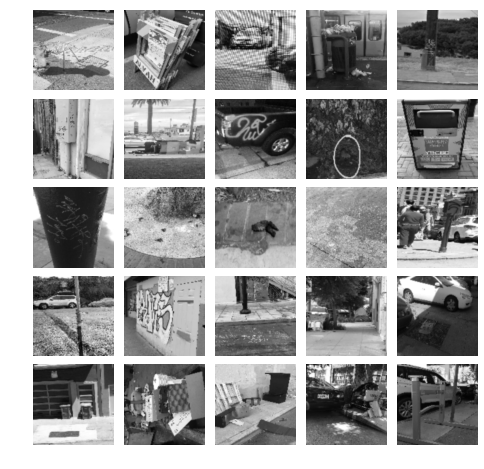

In [12]:
# Visualizing dataset
fig, axes1 = plt.subplots(5, 5, figsize=(8, 8))
for j in range(5):
    for k in range(5):
        # Select 25 random images to visualize.
        i = np.random.choice(range(len(X_flat)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_flat[i:i+1][0].reshape(128, 128),
                           cmap='gray',
                           interpolation='gaussian')
        
# Reduce the spacing between images
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Variables

This splits the image data, the categorical data, and the outputs into training sets and test sets.  The output data is label encoded.  Since a pretrained network is used, the image data will have 3 channels, but they will all be identical since they are grayscale images.  A variance threshold of 0.9995 is used to remove one hot encoded categorical features that are 0 or 1 in the majority of the samples.  This eliminates about half of the categorical features and helps to prevent overfitting.  SelectKBest was also tried to further reduce the feature space, but it made the performance of the model worse and did not significantly improve the modeling speed.

In [13]:
# Set random state for repeatability.  Do not use a different random state
# for the categorical and image data.  Test size also needs to be the same
# for both train_test_splits or the labels will no longer align with the
# samples for the categorical data.

rand_state = 38
features = ['month', 'day', 'neighborhood', 'street']
num_classes = 16
test_size = 0.25

# Label encode labels
X_train, X_test, y_train, y_test = train_test_split(X_flat, 
                                                    df['group'], 
                                                    test_size=test_size,
                                                    random_state=rand_state)

# Output data label encoded and then converted to Keras categorical
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train = keras.utils.to_categorical(y_train_enc, num_classes)
y_test = keras.utils.to_categorical(y_test_enc, num_classes)

# Look at number of training and test samples
print('Overall Shape:')
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')

# Select features and one hot encode
X_cat = df[features]
ohe = OneHotEncoder()
X_cat = ohe.fit_transform(X_cat)
print('\nCategorical Variables:')
print(X_cat.shape[1], 'Features after One Hot Encoding')

# Need to use same random_state as before to make sure that the image data
# and the categorical data are still aligned
X_cat_train, X_cat_test = train_test_split(X_cat, 
                                           test_size=test_size,
                                           random_state=rand_state)

# Select features with variance threshold of 99.95%
# 1 or 0 in more than 99.95% of samples
sel = VarianceThreshold(threshold=(.9995*(1-.9995)))
X_sel_train = sel.fit_transform(X_cat_train)
X_sel_test = sel.transform(X_cat_test)
print(X_sel_train.shape[1], 'Features after variance threshold')

Overall Shape:
123381 training samples
41128 test samples

Categorical Variables:
2180 Features after One Hot Encoding
473 Features after variance threshold


# Plotting Functions
The first function is used to plot the multiclass ROC curves and calculate micro and macro AUC.  Most of this code comes directly from the sklearn multiclass ROC page, which is an excellent reference on the topic. https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
<br><br>
The second function plots the accuracy and loss of the training and test datasets as the model progresses through epochs.  Keras documentation is a great reference for this.  https://keras.io/visualization/

In [0]:
# This function plots the ROC curves and calculates the micro and macro AUC.  It
# also prints a list of the names of the classes corresponding to the label 
# encoded values.  
def plot_rocs(y_score):
  # Line width
  lw = 2

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(num_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= num_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr['micro'], tpr['micro'],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['micro']),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr['macro'], tpr['macro'],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['macro']),
           color='navy', linestyle=':', linewidth=4)

  # Need the same number of colors as classes or the colors will repeat
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple', 'green', 
                  'blue', 'pink', 'brown', 'red', 'teal', 'orange', 'lime',
                  'magenta', 'yellow', 'grey', 'olive', 'bright purple', 'cyan',
                  'lavender'])

  # Print each of the 
  for i, color in zip(range(num_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of {0} (area = {1:0.2f})'.format(i, roc_auc[i]))


  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC')
  # Put a legend to the right of the current axis
  plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
  plt.show()

  for i in range(0, num_classes):
    print('{}: {}'.format(i, le.inverse_transform([i])[0]))

In [0]:
def plot_loss(acc, val_acc, loss, val_loss):
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Train')
  plt.plot(epochs, val_acc, 'r', label='Test')
  plt.title('Model Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Train')
  plt.plot(epochs, val_loss, 'r', label='Test')
  plt.title('Model Loss')
  plt.legend()

  plt.show()

# Generators

## Generator to convert to 3 channel grayscale. 
This is used for VGG or other pretrained models on RGB channels.  My dataset was converted to grayscale on download to conserve RAM, so now in order to utilize these models, I need to triplicate the grayscale channel.  This generator is for images to three channel models.  My generator randomnly selects the same number of images as there are features in the data set for each batch. This means that some images are likely used more than once over the course of an epoch and some are not used at all.  Over the course of several epochs and due to the size of this dataset, this should be acceptable.  Alternate solutions would be to go through the dataset in order or to track the indices that are utilized and not repeat them.

The validation generator goes through the data in order. 

In [0]:
# This generator is for converting the images to 3 channel grayscale images
def generator(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#

  while True:
    
    batch_features = np.zeros((batch_size, dim1, dim2))
    batch_labels = np.zeros((batch_size, num_classes))
  
    for i in range(batch_size):
      # Choose random index in features
      # Some indexes will be repeated, but over the size of the dataset
      # this is not an issus. Alternatively, could make a Sequence object 
      # to only use once or track index using.
      index = random.choice(len(features),1)
      sample = features[index]
      sample = sample.reshape(dim1, dim2)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    batch_features = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.astype('float32')
    batch_features /=255
    yield batch_features, batch_labels
    
# This generator creates the validation data set for the 3 channel grayscale 
# images.  
def val_generator(features, labels, batch_size):

  samples_per_epoch = features.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter = 0

  while True:

    # For validation, need to be sure each image is viewed once
    # Can index in order because we are not training
    index_list = range(batch_size*counter, 
                       min(batch_size*(counter+1), features.shape[0]))
    batch_features = np.array(features[index_list])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], dim1, dim2)
    # Triplicate gray scale on all three axis
    batch_features = np.repeat(batch_features[..., np.newaxis], 3, -1)
    # Scale values
    batch_features /= 255
    # Get the labels
    batch_labels = np.array(labels[index_list])
    
    counter += 1
    yield batch_features, batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

## Generator to Combine 3 Models
This generator outputs 128x128x1 image batch data for my CNN model, a 128x128,x3 image batch data for VGG16 or a similar model, and the categorical batch data for the MLP model.  The training generator randomnly select data, the test generator goes through the data in order.

In [0]:
# This generator is used for combing 
def generator_three(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#

  features_cnn, features_mlp = features

  while True:
    
    batch_features = np.zeros((batch_size, dim1, dim2))
    batch_labels = np.zeros((batch_size, num_classes))
    index_list = []
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(features_cnn.shape[0])
      index_list.append(index)
      sample = features_cnn[index]
      sample = sample.reshape(dim1, dim2)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    batch_features = batch_features.astype('float32')
    batch_features /=255
    
    # Three channels for pseudo RGB, 1 channel for CNN
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.reshape(batch_size, dim1, dim2, 1)
    
    # fit_generator does not accept sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
    
    yield [batch_features, batch_features3, batch_mlp], batch_labels
    

# size = batch_size for val_generator_three    
def val_generator_three(features, labels, size):
  
  features_cnn, features_mlp = features
  samples_per_epoch = features_cnn.shape[0]
  number_of_batches = samples_per_epoch/size
  counter = 0

  while True:
    index_list = range(size*counter, 
                       min(size*(counter+1), features_cnn.shape[0]))
    
    batch_features = np.array(features_cnn[index_list])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], dim1, dim2)
    batch_features /=255
    
    # Three channels for pseudo rgb, 1 channel for not
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.reshape(batch_features.shape[0], dim1, dim2, 1)
  
    batch_labels = np.array(labels[index_list])
    
    # Fit_generator doesn't like sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
                              
      
    counter += 1
    yield [batch_features, batch_features3, batch_mlp], batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

## Generator to combine VGG and categorical

In [0]:
# This generator is used for combining
def generator_two(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#
    
  features_cnn, features_mlp = features
  batch_features3 = np.zeros((batch_size, 128, 128, 3))

  while True:
    
    index_list = []
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(features_cnn.shape[0])
      index_list.append(index)

    batch_features = features_cnn[index_list]
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128).astype('float32')
    batch_features = batch_features.astype('float32')
    batch_features /=255
    
    # Three channels for pseudo RGB, 1 channel for CNN
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    #print(batch_features3[0])
    batch_features3[:, :, :, 0] = batch_features
    batch_features3[:, :, :, 1] = batch_features
    batch_features3[:, :, :, 2] = batch_features
    #print(batch_features3[0])
    #batch_features = batch_features.reshape(batch_size, 128, 128, 1)
    
    # fit_generator does not accept sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
    batch_labels = np.array(labels[index_list])
    
    yield [batch_features3, batch_mlp], batch_labels
    

# size = batch_size for val_generator_three    
def val_generator_two(features, labels, size):
  
  features_cnn, features_mlp = features
  samples_per_epoch = features_cnn.shape[0]
  number_of_batches = samples_per_epoch/size
  counter = 0

  while True:
    index_list = range(size*counter, 
                       min(size*(counter+1), features_cnn.shape[0]))
    
    batch_features = np.array(features_cnn[index_list])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128)
    batch_features /=255
    
    # Three channels for pseudo rgb, 1 channel for not
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    #batch_features = batch_features.reshape(batch_features.shape[0], 128, 128, 1)
  
    batch_labels = np.array(labels[index_list])
    
    # Fit_generator doesn't like sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
                              
      
    counter += 1
    yield [batch_features3, batch_mlp], batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

# Unify Generators

In [0]:
# This generator is used for combing 
def generator_all(features, 
                  labels, 
                  batch_size, 
                  one_chan=True, 
                  three_chan=True, 
                  categoricals=True):
  
  if ((one_chan or three_chan) and categoricals): 
    features_image, features_cat = features
    train_size = features_image[0]
  
  elif (one_chan or three_chan):
    features_image = features
  
  else:
    features_cat = features
    train_size = features_cat.shape[0]

  while True:
    if one_chan or three_chan:
      batch_features = np.zeros((batch_size, dim1, dim2))
    batch_labels = np.zeros((batch_size, num_classes))
    index_list = []
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(train_size)
      index_list.append(index)
      if one_chan or three_chan:
        sample = features_image[index]
        sample = sample.reshape(dim1, dim2)
        batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    if one_chan or three_chan:
      batch_features = batch_features.astype('float32')
      batch_features /=255
    
    # Three channels for pseudo RGB, 1 channel for CNN
    if three_chan:
      batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    if one_chan:
      batch_features = batch_features.reshape(batch_size, dim1, dim2, 1)
    
    # fit_generator does not accept sparse matrices
    if categoricals:
      batch_mlp = np.array(features_cat[index_list].todense())
    
    yield_data = []
    if one_chan == True:
      yield_data.append(batch_features)
    if three_chan == True:
      yield_data.append(batch_features3)
    if categoricals == True:
      yield_data.append(batch_mlp)
      
    yield yield_data, batch_labels
      
  
  else:
    features_cat = features
    train_size = features_cat.shape[0]
    yield [batch_features, batch_features3, batch_mlp], batch_labels
    

# size = batch_size for val_generator_three    
def val_generator_all(features, 
                      labels, 
                      size,
                      one_chan=True, 
                      three_chan=True, 
                      categoricals=True):
  
  if (one_chan or three_chan) and categoricals: 
    features_image, features_cat = features
    samples_per_epoch = features_image[0]
  
  elif (one_chan or three_chan):
    features_image = features
  
  else:
    features_cat = features
    samples_per_epoch = features_cat.shape[0]
    
  number_of_batches = samples_per_epoch/size
  counter = 0

  while True:
    index_list = range(size*counter, 
                       min(size*(counter+1), samples_per_epoch))
    
    if (one_chan or three_chan):
      batch_features = np.array(features_image[index_list])
      batch_features = batch_features.astype('float32')
      batch_features = batch_features.reshape(batch_features.shape[0], dim1, dim2)
      batch_features /=255
    
    if three_chan:
    # Three channels for pseudo rgb, 1 channel for not
      batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    
    if one_chan:
      batch_features = batch_features.reshape(size, 128, 128, 1)
  
    batch_labels = np.array(labels[index_list])
    
    if categoricals:
      # Fit_generator doesn't like sparse matrices
      batch_mlp = np.array(features_mlp[index_list].todense())
                              
      
    counter += 1
    
    yield_data = []
    if one_chan == True:
      yield_data.append(batch_features)
    if three_chan == True:
      yield_data.append(batch_features3)
    if categoricals == True:
      yield_data.append(batch_mlp)
      
    yield yield_data, batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

In [20]:
one = [3, 4, 5]
two = [1, 0, 1]

list(compress(one, two))

[3, 5]

## Generator CNN only

In [0]:
# No need to triplicate axis if not using with VGG, etc
def generator_cnn(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#

  while True:
    
    batch_features = np.zeros((batch_size, dim1, dim2, 1))
    batch_labels = np.zeros((batch_size, num_classes))
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(len(features),1)
      sample = features[index]
      sample = sample.reshape(dim1, dim2, 1)
      
      #print(features[index].shape)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    batch_features = batch_features.astype('float32')
    batch_features /=255
    yield batch_features, batch_labels
    
def val_generator_cnn(features, labels, batch_size):

  samples_per_epoch = features.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter = 0

  while True:
    index_list = range(batch_size*counter, 
                       min(batch_size*(counter+1), samples_per_epoch))
    
    batch_features = np.array(features[index_list])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], 
                                            dim1, 
                                            dim2, 
                                            1)
    batch_features /=255
    
    batch_labels = np.array(labels[index_list])
    counter += 1
    yield batch_features, batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

# Convolutional Neural Network
- Convolutional Neural Network
- Black and White 128x128 images
- Model performs much worse if filters set to 64, 128, 256

In [22]:
input_shape_cnn = (dim1, dim2, 1)

inputs_cnn = Input(shape=input_shape_cnn)
chan_dim = -1

x1 = Conv2D(32, (3, 3), padding='same')(inputs_cnn)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(32, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(64, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(64, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(128, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(128, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)
x1 = Dense(num_classes)(x1)
out_cnn = Activation('softmax')(x1)

cnn = Model(inputs_cnn, out_cnn)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_cnn.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

# fits the model on batches with real-time data augmentation:
history_cnn = cnn.fit_generator(generator_cnn(X_train, y_train, 256), 
                                steps_per_epoch=480,
                                verbose=1,
                                epochs=25,
                                validation_data=val_generator_cnn(X_test, y_test, 32),
                                validation_steps=X_test.shape[0]/32,
                                callbacks=callbacks)

y_score_cnn = cnn.predict_generator(val_generator_cnn(X_test, y_test, 32),
                                    steps=X_test.shape[0]/32)


Instructions for updating:
Use tf.cast instead.
Epoch 1/25
480/480 [==============================] - 93s 194ms/step - loss: 2.2886 - acc: 0.3014 - val_loss: 1.9884 - val_acc: 0.3646
Epoch 2/25
480/480 [==============================] - 87s 182ms/step - loss: 1.8878 - acc: 0.3958 - val_loss: 1.8325 - val_acc: 0.4134
Epoch 3/25
480/480 [==============================] - 87s 182ms/step - loss: 1.7455 - acc: 0.4445 - val_loss: 1.7528 - val_acc: 0.4448
Epoch 4/25
480/480 [==============================] - 88s 183ms/step - loss: 1.6595 - acc: 0.4714 - val_loss: 1.7937 - val_acc: 0.4327
Epoch 5/25
480/480 [==============================] - 88s 182ms/step - loss: 1.6092 - acc: 0.4855 - val_loss: 1.6794 - val_acc: 0.4684
Epoch 6/25
480/480 [==============================] - 87s 182ms/step - loss: 1.5665 - acc: 0.5001 - val_loss: 1.6065 - val_acc: 0.4893
Epoch 7/25
480/480 [==============================] - 88s 183ms/step - loss: 1.5331 - acc: 0.5098 - val_loss: 1.7746 - val_acc: 0.4466
Epoch 8

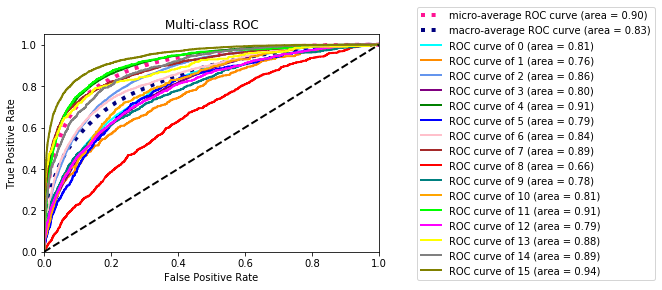

0: Bulky Items
1: Damaged Property
2: Encampments
3: General Cleaning
4: Graffiti
5: Hazardous Materials
6: Human or Medical Waste
7: Litter Receptacles
8: Other
9: Rec and Park Requests
10: Sewer Issues
11: Signs - Illegal Postings and Repair
12: Street and Sidewalk Issues
13: Streetlights
14: Tree Maintenance
15: Vehicle


In [26]:
plot_rocs(y_score_cnn)

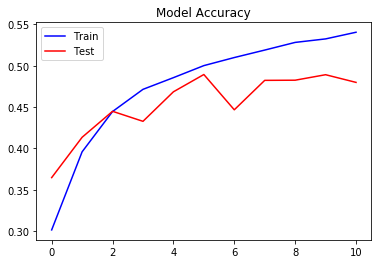

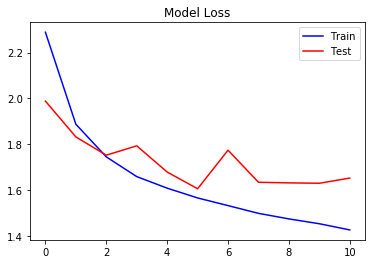

In [24]:
acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

In [0]:
from keras.utils import plot_model
plot_model(cnn, to_file='cnn.png')

In [0]:
from google.colab import files
files.download( "best_model_cnn.h5")    

In [29]:
print( os.getcwd() )
print( os.listdir() )

/content
['.config', 'cnn.png', 'best_model_cnn.h5', 'drive', 'sample_data']


# VGG16
I next used a pre-trained model, VGG16, to classify the data.  VGG16 has 16 layers and is used for large-scale image classification.  It is one of the top pre-trained models for images and is easy to implement.  It only accepts RGB data, so in order to train it on my gray scale images, the generator needs to triplicate the grayscale data and send it to all three channels.  

In [33]:
vgg_conv = VGG16(weights='imagenet', include_top=False)


# Freeze the layers except the last 4 layers.  This saves the
# time of retraining all the other layers and takes advantage of
# the training that was already performed on the model.
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

input_shape_vgg = (dim1, dim2, 3)
# This returns a tensor
inputs_vgg = Input(shape=input_shape_vgg)
chan_dim = -1

# Add VCG layer on top
x2 = vgg_conv(inputs_vgg)

x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
x2 = Dense(num_classes)(x2)
out_vgg = Activation('softmax')(x2)

vgg = Model(inputs_vgg, out_vgg)

58892288/58889256 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f97c0ab4940> False
<keras.layers.convolutional.Conv2D object at 0x7f97c0ab4550> False
<keras.layers.convolutional.Conv2D object at 0x7f97c0ab4860> False
<keras.layers.pooling.MaxPooling2D object at 0x7f97c0aaf470> False
<keras.layers.convolutional.Conv2D object at 0x7f97c0aaf048> False
<keras.layers.convolutional.Conv2D object at 0x7f97c0ab1d30> False
<keras.layers.pooling.MaxPooling2D object at 0x7f97c3ff4e10> False
<keras.layers.convolutional.Conv2D object at 0x7f97c0aad390> False
<keras.layers.convolutional.Conv2D object at 0x7f97be6ff630> False
<keras.layers.convolutional.Conv2D object at 0x7f97be6c9400> False
<keras.layers.pooling.MaxPooling2D object at 0x7f97beb55b00> False
<keras.layers.convolutional.Conv2D object at 0x7f97beb55630> False
<keras.layers.convolutional.Conv2D object at 0x7f97beb7c518> False
<keras.layers.convolutional.Conv2D object at 0x7f97c32aa4e0> F

In [34]:
vgg.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_vgg16.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]


# fits the model on batches with real-time data augmentation:
history_vgg = vgg.fit_generator(generator(X_train, y_train, 256), 
                                steps_per_epoch=480,
                                verbose=1,
                                epochs=15,
                                validation_data=val_generator(X_test, y_test, 32),
                                validation_steps=X_test.shape[0]/32,
                                callbacks=callbacks)


y_score_vgg = vgg.predict_generator(val_generator(X_test, y_test, 32),
                                    steps=X_test.shape[0]/32)


Epoch 1/15
480/480 [==============================] - 301s 627ms/step - loss: 1.8899 - acc: 0.4004 - val_loss: 1.6229 - val_acc: 0.4986
Epoch 2/15
480/480 [==============================] - 293s 611ms/step - loss: 1.5169 - acc: 0.5224 - val_loss: 1.5309 - val_acc: 0.5240
Epoch 3/15
480/480 [==============================] - 293s 611ms/step - loss: 1.3731 - acc: 0.5680 - val_loss: 1.5171 - val_acc: 0.5336
Epoch 4/15
480/480 [==============================] - 293s 611ms/step - loss: 1.2520 - acc: 0.6030 - val_loss: 1.5732 - val_acc: 0.5234
Epoch 5/15
480/480 [==============================] - 294s 611ms/step - loss: 1.1199 - acc: 0.6474 - val_loss: 1.6176 - val_acc: 0.5234
Epoch 6/15
480/480 [==============================] - 293s 611ms/step - loss: 0.9737 - acc: 0.6943 - val_loss: 1.7860 - val_acc: 0.5320
Epoch 7/15
480/480 [==============================] - 293s 611ms/step - loss: 0.8575 - acc: 0.7327 - val_loss: 1.8818 - val_acc: 0.5222
Epoch 8/15
480/480 [============================

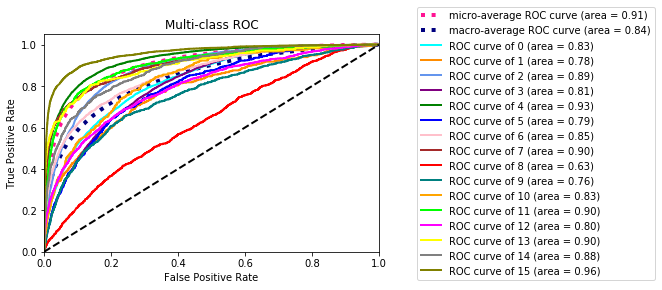

0: Bulky Items
1: Damaged Property
2: Encampments
3: General Cleaning
4: Graffiti
5: Hazardous Materials
6: Human or Medical Waste
7: Litter Receptacles
8: Other
9: Rec and Park Requests
10: Sewer Issues
11: Signs - Illegal Postings and Repair
12: Street and Sidewalk Issues
13: Streetlights
14: Tree Maintenance
15: Vehicle


In [35]:
plot_rocs(y_score_vgg)

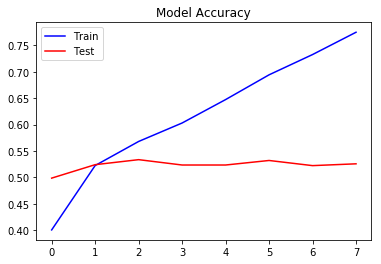

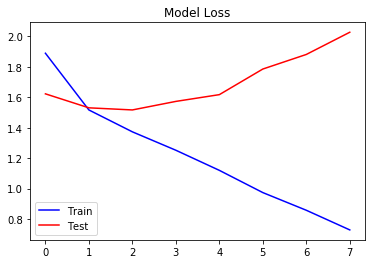

In [36]:
acc = history_vgg.history['acc']
val_acc = history_vgg.history['val_acc']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

In [37]:
from google.colab import files
files.download('best_model_cnn.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 49358, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

# Multilayer Perceptron (MLP)

In [0]:
# MLP model for categorical variables
input_shape_cat = X_sel_train.shape[1]

# This returns a tensor
inputs_cat = Input(shape=(input_shape_cat,))

# a layer instance is callable on a tensor and returns a tensor
x = Dense(128, activation='relu')(inputs_cat)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
out_mlp = Dense(num_classes, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
mlp = Model(inputs=inputs_cat, outputs=out_mlp)

In [0]:
# Compile the model
mlp.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

# Set the callbacks and a filepath for saving the model
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_mlp.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

# Fit the model - do not need a data generator, everything already in RAM
history_mlp = mlp.fit(X_sel_train, y_train,
                      batch_size=128,
                      epochs=20,
                      verbose=1,
                      callbacks=callbacks,
                      validation_data=(X_sel_test, y_test))
score_mlp = mlp.evaluate(X_sel_test, y_test, verbose=0)
y_score_mlp = mlp.predict(X_sel_test)

print('Test loss:', score_mlp[0])
print('Test accuracy:', score_mlp[1])

Train on 111057 samples, validate on 37019 samples
Epoch 1/20
111057/111057 [==============================] - 6s 52us/step - loss: 2.0054 - acc: 0.3371 - val_loss: 2.0516 - val_acc: 0.3214
Epoch 2/20
111057/111057 [==============================] - 4s 34us/step - loss: 2.0028 - acc: 0.3388 - val_loss: 2.0483 - val_acc: 0.3212
Epoch 3/20
111057/111057 [==============================] - 4s 35us/step - loss: 1.9981 - acc: 0.3389 - val_loss: 2.0519 - val_acc: 0.3203
Epoch 4/20
111057/111057 [==============================] - 4s 35us/step - loss: 1.9931 - acc: 0.3399 - val_loss: 2.0485 - val_acc: 0.3206
Test loss: 2.048456809957319
Test accuracy: 0.32064615466847224


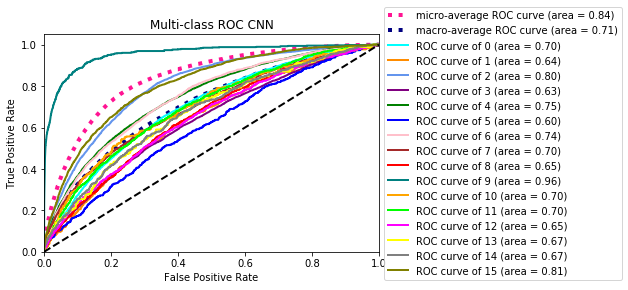

0: Bulky Items
1: Damaged Property
2: Encampments
3: General Cleaning
4: Graffiti
5: Hazardous Materials
6: Human or Medical Waste
7: Litter Receptacles
8: Other
9: Rec and Park Requests
10: Sewer Issues
11: Signs - Illegal Postings and Repair
12: Street and Sidewalk Issues
13: Streetlights
14: Tree Maintenance
15: Vehicle


In [0]:
plot_rocs(y_score_mlp)

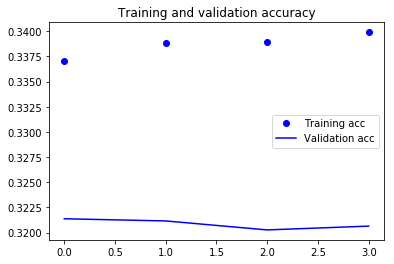

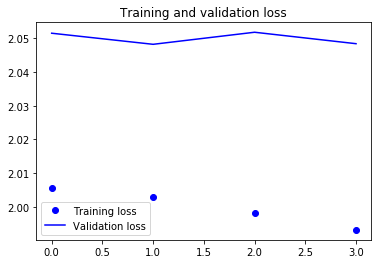

In [0]:
acc = history_mlp.history['acc']
val_acc = history_mlp.history['val_acc']
loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

# Combine Models - All 3
- Don't include dropout after models are combined - makes models much worse

In [0]:
# combine the output of previous two models
combined_input = concatenate([cnn.output, vgg.output, mlp.output])

# Final Fully Connected layer head, 2 dense layers
x3 = Dense(48, activation='relu')(combined_input)
#x3 = Dropout(0.5)(x3)
#x3 = Dense(64, activation='relu')(x3)
#x3 = Dropout(0.25)(x3)
x3 = Dense(num_classes, activation='softmax')(x3)
                              
# Final model accepts input from both mlp and cnn
model3 = Model(inputs=[cnn.input, vgg.input, mlp.input], outputs=x3)

model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model_all3.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model3.fit_generator(generator_three([X_train, X_sel_train], 
                                              y_train, 
                                              32),
                              steps_per_epoch=2800,
                              verbose=1,
                              validation_data=val_generator_three([X_test, X_sel_test], 
                                                                  y_test, 
                                                                  32),
                              validation_steps=X_test.shape[0]/32,
                              epochs=10,
                              callbacks=callbacks)

y_score_three = model3.predict_generator(val_generator_three([X_test, X_sel_test], 
                                                             y_test, 
                                                             32),
                                         steps=X_test.shape[0]/32)

Epoch 1/10
2800/2800 [==============================] - 326s 116ms/step - loss: 1.8201 - acc: 0.4360 - val_loss: 1.7320 - val_acc: 0.4565
Epoch 2/10
2800/2800 [==============================] - 321s 115ms/step - loss: 1.6675 - acc: 0.4842 - val_loss: 1.8673 - val_acc: 0.4169
Epoch 3/10
2800/2800 [==============================] - 322s 115ms/step - loss: 1.6140 - acc: 0.4982 - val_loss: 1.9220 - val_acc: 0.4018
Epoch 4/10
2800/2800 [==============================] - 321s 115ms/step - loss: 1.5703 - acc: 0.5119 - val_loss: 1.6623 - val_acc: 0.4832
Epoch 5/10
2800/2800 [==============================] - 321s 115ms/step - loss: 1.5245 - acc: 0.5263 - val_loss: 1.5935 - val_acc: 0.5014
Epoch 6/10
2800/2800 [==============================] - 321s 115ms/step - loss: 1.4983 - acc: 0.5328 - val_loss: 1.5560 - val_acc: 0.5143
Epoch 7/10
2800/2800 [==============================] - 323s 115ms/step - loss: 1.4657 - acc: 0.5415 - val_loss: 1.8889 - val_acc: 0.4242
Epoch 8/10
2800/2800 [============

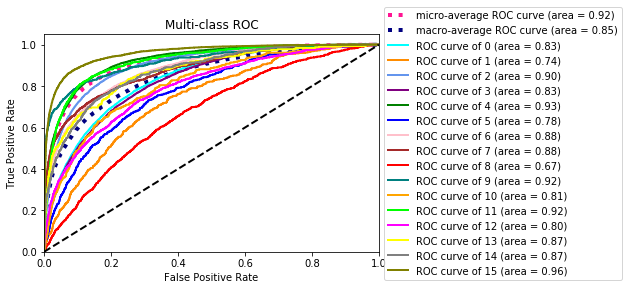

0: Bulky Items
1: Damaged Property
2: Encampments
3: General Cleaning
4: Graffiti
5: Hazardous Materials
6: Human or Medical Waste
7: Litter Receptacles
8: Other
9: Rec and Park Requests
10: Sewer Issues
11: Signs - Illegal Postings and Repair
12: Street and Sidewalk Issues
13: Streetlights
14: Tree Maintenance
15: Vehicle


In [0]:
plot_rocs(y_score_three)

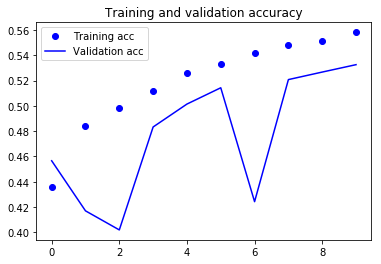

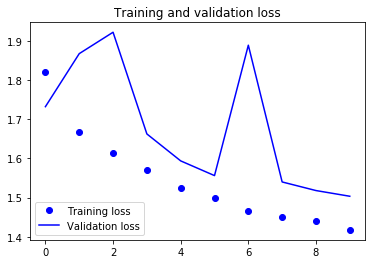

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

# Combine 2  - VGG and categorical
- Don't use dropout after models are combined

In [0]:
# combine the output of previous two models
combined_input_2 = concatenate([vgg.output, mlp.output])

# Final Fully Connected layer head, 2 dense layers
x5 = Dense(32, activation='relu')(combined_input_2)
x5 = Dropout(0.5)(x5)
x5 = Dense(64, activation='relu')(x5)
x5 = Dropout(0.5)(x5)
x5 = Dense(num_classes, activation='softmax')(x5)
                              
# Final model accepts input from both mlp and cnn
model_two = Model(inputs=[vgg.input, mlp.input], outputs=x5)

model_two.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model_two.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history_two = model_two.fit_generator(generator_two([X_train, X_sel_train], 
                                                     y_train, 
                                                     32),
                                      steps_per_epoch=2800,
                                      verbose=1,
                                      validation_data=val_generator_two([X_test, 
                                                                         X_sel_test], 
                                                                         y_test, 
                                                                         32),
                                      validation_steps=X_test.shape[0]/32,
                                      epochs=15,
                                      callbacks=callbacks)

y_score_three = model_two.predict_generator(val_generator_two([X_test, X_sel_test], 
                                                           y_test, 
                                                           32),
                                            steps=X_test.shape[0]/32)

Epoch 1/15
2800/2800 [==============================] - 266s 95ms/step - loss: 2.1970 - acc: 0.2892 - val_loss: 2.1285 - val_acc: 0.3035
Epoch 2/15
2800/2800 [==============================] - 260s 93ms/step - loss: 2.1450 - acc: 0.3122 - val_loss: 2.1247 - val_acc: 0.3111
Epoch 3/15
2438/2800 [=========================>....] - ETA: 25s - loss: 2.1298 - acc: 0.3175

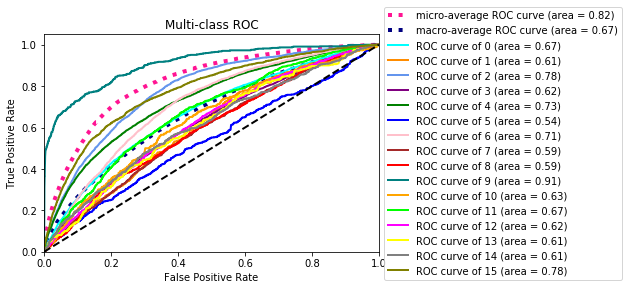

0: Bulky Items
1: Damaged Property
2: Encampments
3: General Cleaning
4: Graffiti
5: Hazardous Materials
6: Human or Medical Waste
7: Litter Receptacles
8: Other
9: Rec and Park Requests
10: Sewer Issues
11: Signs - Illegal Postings and Repair
12: Street and Sidewalk Issues
13: Streetlights
14: Tree Maintenance
15: Vehicle


In [0]:
plot_rocs(y_score_three)

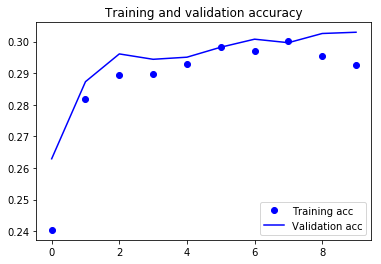

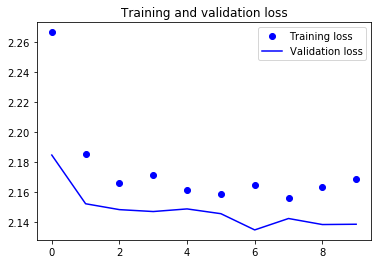

In [0]:
acc = history_two.history['acc']
val_acc = history_two.history['val_acc']
loss = history_two.history['loss']
val_loss = history_two.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

In [0]:
from google.colab import files
files.download('best_model_all.h5')

# References:
Convert to grayscale: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/12201744#12201744

Keras early stopping: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/

Grayscale Keras: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/

Combining models: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

Using a pretrained network: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

ROC Curves: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
